In [1]:
import pathlib
import sys

import cv2
import numpy as np
import skimage
import tifffile
from tqdm import tqdm

sys.path.append("../src/")
import image_utils  # noqa

%load_ext autoreload
%autoreload 2

## Load all of the raw images

These are the TIFFs produced by `convert_nd2.py` script using:
```sh
python scripts/convert_nd2.py convert-dir 
    --input-dirpath ~/data/s3-cache/2024-worm-motility \
    --output-dirpath processed-data/2024-worm-motility 
```

In [2]:
# Find all of the tiff files in the data directory.
data_dirpath = pathlib.Path("../processed-data").absolute()
filepaths = [
    dirpath / filename
    for dirpath, _, filenames in data_dirpath.walk()
    for filename in filenames
    if filename.endswith(".tiff")
]
len(filepaths)

46

In [3]:
# Load all of the images (this is a little slow; it could be parallelized).
raw_ims = [tifffile.imread(filepath) for filepath in tqdm(filepaths)]
len(raw_ims)

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:02<00:00, 17.14it/s]


46

## Exploratory visualization

In [4]:
# Create min-intensity projections of all FOVs and stack them into a single array.
raw_ims_proj = np.stack([im.min(axis=0) for im in raw_ims])
raw_ims_proj.shape

(46, 512, 512)

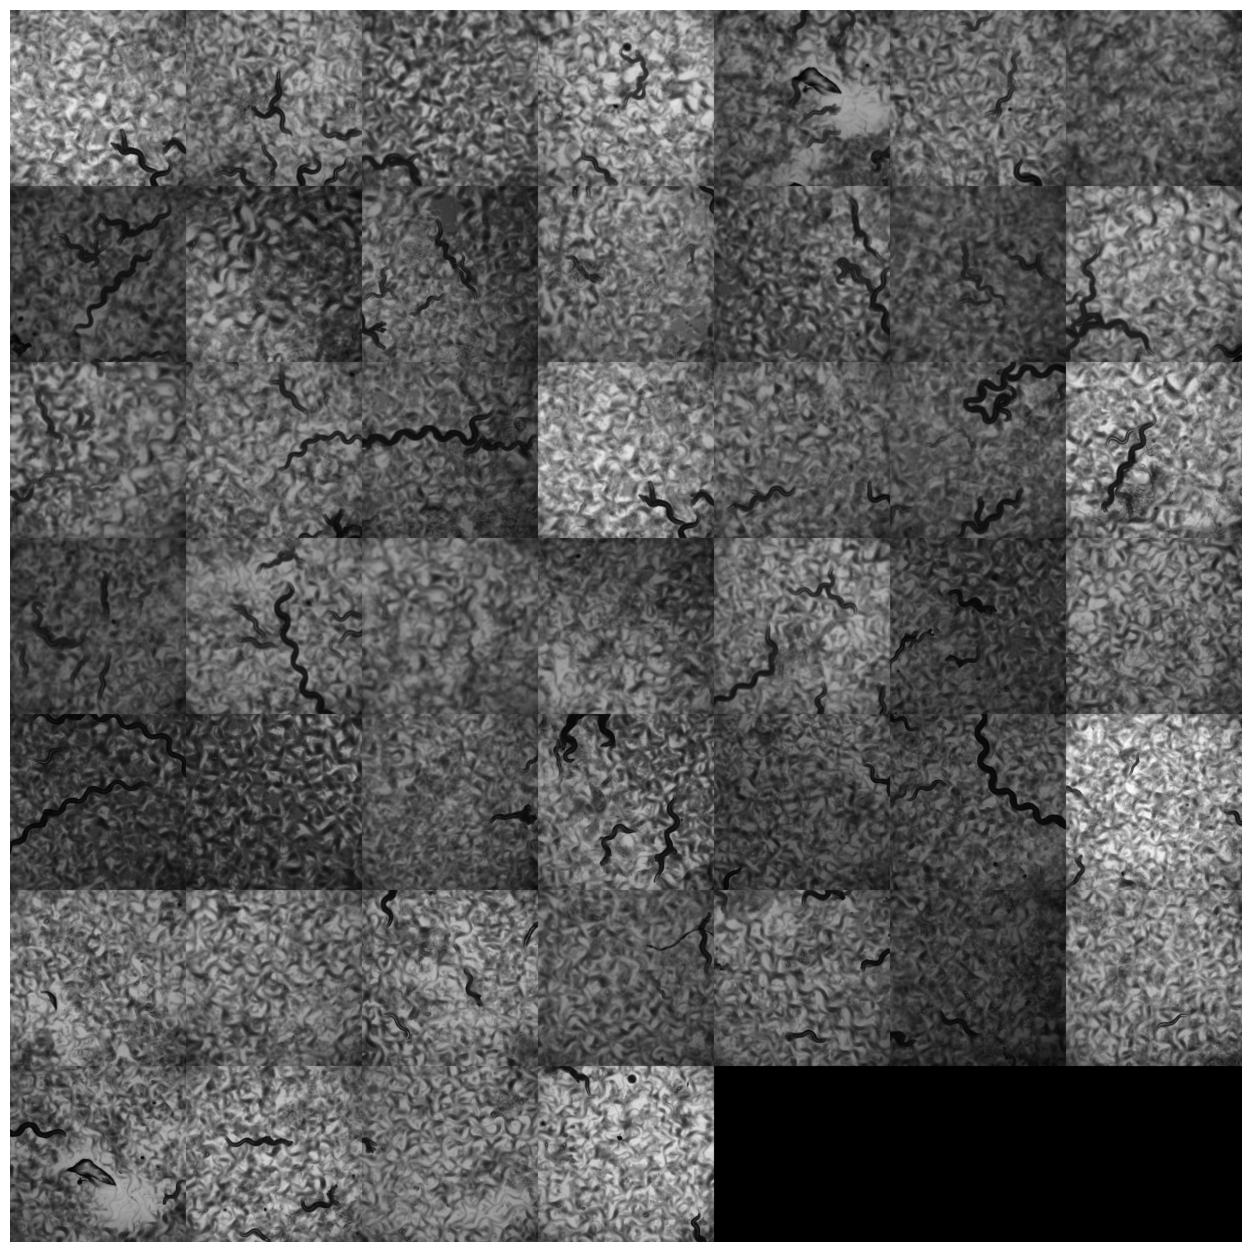

In [5]:
# Reshape the min-projections to a 2D tiled array.
n = 7
m = np.ceil(len(raw_ims_proj) / n).astype(int)

xy_size = raw_ims_proj.shape[1]

# Pad the array with zeros so that it is a multiple of n.
tiled_image = np.zeros((n * m, xy_size, xy_size), dtype=raw_ims_proj.dtype)
tiled_image[: len(raw_ims_proj)] = raw_ims_proj

# Reshape to a 2D grid of individual FOV projections.
tiled_image = (
    tiled_image.reshape(n, m, xy_size, xy_size)
    .transpose(0, 2, 1, 3)
    .reshape(n * xy_size, m * xy_size)
)

image_utils.imshow(tiled_image, figsize=(16, 16))

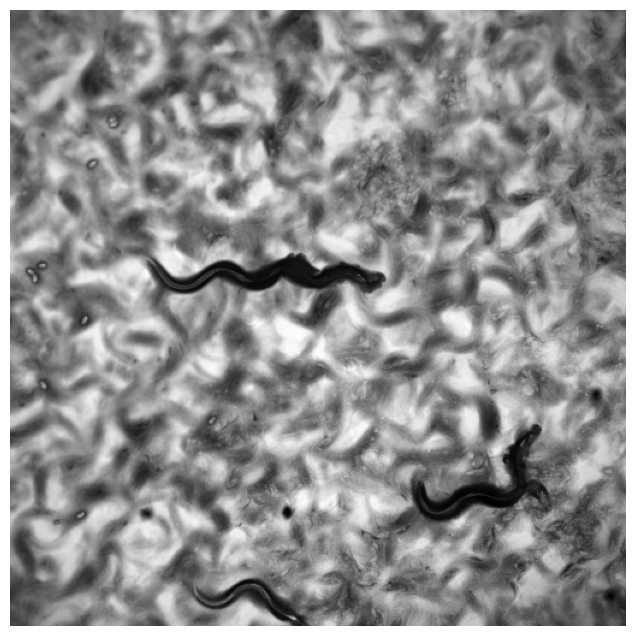

In [6]:
# Inspect single FOVs in the tiled array (I manually counted to figure out the index).
image_utils.imshow(raw_ims_proj[-3, :, :], figsize=(8, 8))

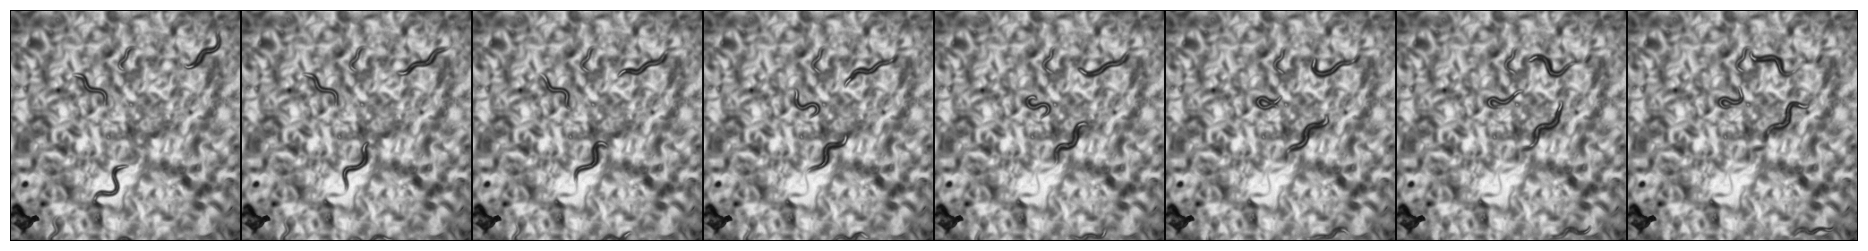

In [8]:
image_utils.imshow(image_utils.tile_image(raw_ims[7], num_timepoints=8), figsize=(24, 3))

In [9]:
# Hand-picked examples of in-focus and out-of-focus images.
example_inds = {
    "in-focus": (-3, 16),
    "out-of-focus": (7, 12),
    "stationary-worms": (-9, -7),
}


def get_example(name, num=None):
    """Convenience function to get an example image by name."""
    for key in example_inds.keys():
        if name in key:
            ind = example_inds[key][num if num is not None else 0]
            return raw_ims[ind].copy()

## Background subtraction

This section reimplements the background subtraction in `background_subtraction_pharaglow.py`, just as a sanity check.

In [10]:
def subtract_background(im):
    """
    Subtract the mean intensity across the first dimension (time) from each frame.
    Since most of the background is unchanging, except for where the worm crawls,
    this has the effect of removing most of the background.

    TODO: it also has the effect of removing worms that don't move, so it might be better
    to eliminate this step.
    """
    if im.ndim < 3:
        raise ValueError("Input must be a 3D array with dimensions (time, x, y).")

    im = im.astype(np.float32)
    # Use the mean instead of the median because they will be nearly the same and mean is faster,
    # and also subsample in time dimension to further speed up the computation.
    subsample_by = 5
    im -= np.mean(im[::subsample_by, :, :], axis=0)
    im = image_utils.autoscale(im, percentile=100)
    return im

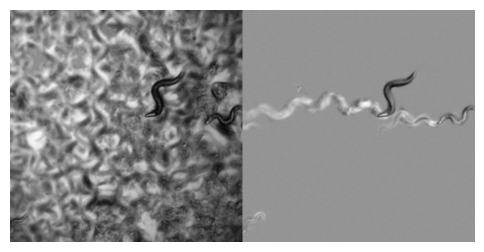

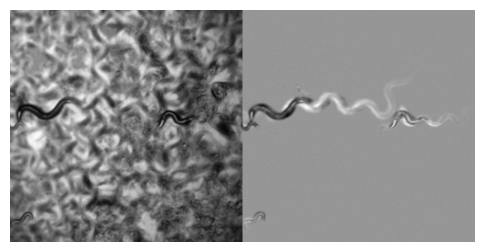

In [11]:
im_raw = get_example("in", 1)
im_bg = subtract_background(im_raw)

for ind in [0, 200]:
    image_utils.imshow(im_raw[ind, :, :], im_bg[ind, :, :], figsize=(6, 6))

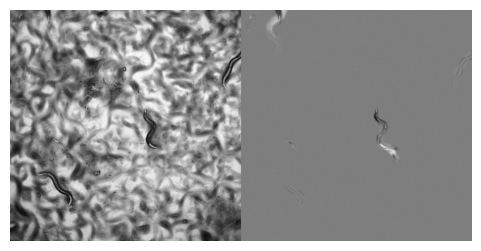

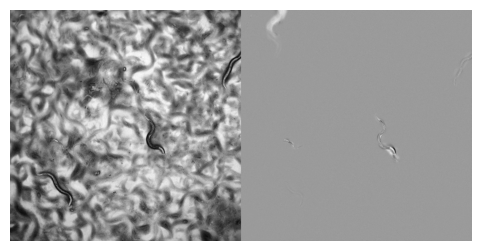

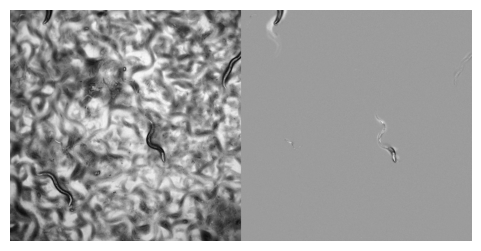

In [34]:
# View an example with stationary worms.
im_raw = get_example("stationary", 0)
im_bg = subtract_background(im_raw)

for ind in [0, 100, 200]:
    image_utils.imshow(im_raw[ind, :, :], im_bg[ind, :, :], figsize=(6, 3))

### Make a crude background mask from the standard deviation across time

The logic of this is that because the true background is unchanging, we can create an approximate mask of the background by taking the standard deviation of the pixel values across time. 

This mask will be imperfect, since some worms don't move much or at all, but it is still useful as a way to estimate background intensity in later steps.

In [12]:
def make_background_mask_from_standard_deviation(im, ind=None):
    """
    Create a binary mask of the background based on the standard deviation of the image.
    """
    if im.ndim < 3:
        raise ValueError("Input image must have at least 3 dimensions.")

    subsample_by = 3
    window = 30
    if ind is not None:
        im = im[max(0, ind - window) : min(ind + window, len(im)), :, :]
        subsample_by = 1

    std = im[::subsample_by, :, :].std(axis=0)
    thresh = skimage.filters.threshold_otsu(std)
    mask = std > thresh
    return std, mask

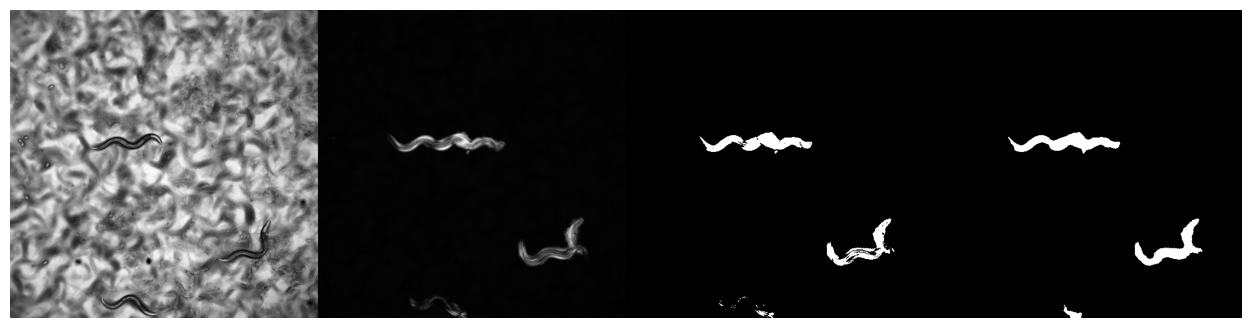

In [13]:
im = get_example("in", 0)

ind = 100
std, mask = make_background_mask_from_standard_deviation(im, ind=None)
image_utils.imshow(im[ind, :, :], std, mask, image_utils.cleanup_mask(mask), figsize=(16, 4))

## Generating a frame-wise background mask

This means generating a binary image where the background is white and the foreground is black. The white regions should correspond to the worms, and the black regions should correspond to the background.

### Generating a frame-wise background mask *after* background subtraction

This appears to be pretty easy: the background-subtracted frames are so clean that a simple thresholding operation is enough to generate a relatively clean frame-wise background mask.

But it has some problems: stationary worms are lost, and the "ghosting" around mobile worms degrades the quality of the background mask.

In [14]:
def make_background_mask_from_background_subtraction(im, ind=None):
    """
    Create a binary mask of the background based on the background-subtracted image
    using a simple intensity threshold.
    """
    frame_bgs_smooth = skimage.filters.gaussian(im, sigma=1)
    thresh = skimage.filters.threshold_otsu(frame_bgs_smooth)
    mask = frame_bgs_smooth < thresh
    return mask

In [15]:
im = get_example("st", 1)
im_bgs = subtract_background(im)

frame = im[0, :, :]
frame_bgs = im_bgs[0, :, :]

mask = make_background_mask_from_background_subtraction(frame_bgs)
image_utils.imshow(frame, frame_bgs, mask, image_utils.cleanup_mask(mask), figsize=(18, 6))

: 

: 

### Generating a background mask *without* background subtraction

The logic of attempting to do this is that it would capture stationary worms and it would avoid the "ghosting" around mobile worms that results from the background subtraction.

In [52]:
def make_background_mask(frame, estimated_background_mask):
    """
    Create a binary mask of the background by thresholding the standard deviation of the image.
    """
    # Use a DoG filter to enhance the edges of the worms.
    # This works by supressing the blurry, low-spatial-frequency background
    # relative to the sharp, high-frequency edges of the worms.
    dog_filtered = skimage.filters.difference_of_gaussians(frame, low_sigma=0.3, high_sigma=3)

    # A built-in skimage filter to find edges seems to work the best.
    # Reference: https://scikit-image.org/docs/stable/auto_examples/edges/plot_ridge_filter.html#ridge-operators.
    edges = skimage.filters.sato(dog_filtered, sigmas=[0.3, 1], black_ridges=True)

    # Find a threshold for the edges using Otsu's method and the estimated background mask.
    thresh = skimage.filters.threshold_otsu(edges[estimated_background_mask])
    mask = edges > thresh

    return mask, dog_filtered, edges

In [53]:
im = get_example("st", 1)
_, mask_from_std_dev = make_background_mask_from_standard_deviation(im)

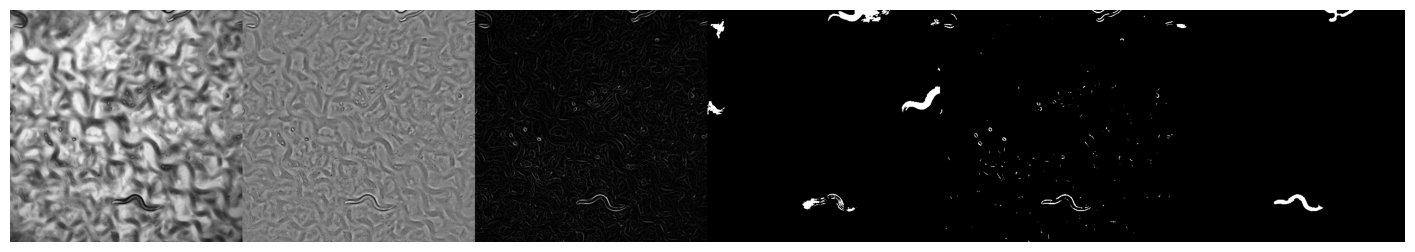

In [54]:
frame = im[99, :, :]

mask, dog_filtered, edges = make_background_mask(frame, estimated_background_mask=mask_from_std_dev)
image_utils.imshow(
    frame,
    dog_filtered,
    edges,
    mask_from_std_dev,
    mask,
    image_utils.cleanup_mask(mask),
    figsize=(18, 6),
)

### Tierpsy-tracker's getROIMask method

In [57]:
def getROIMask(
    image,
    min_area,
    max_area,
    thresh_block_size,
    thresh_C,
    dilation_size,
    keep_border_data,
    is_light_background,
    wells_mask=None,
):
    """
    Calculate a binary mask to mark areas where it is possible to find worms.
    Objects with less than min_area or more than max_area pixels are rejected.
        > min_area -- minimum blob area to be considered in the mask
        > max_area -- max blob area to be considered in the mask
        > thresh_C -- threshold used by openCV adaptiveThreshold
        > thresh_block_size -- block size used by openCV adaptiveThreshold
        > dilation_size -- size of the structure element to dilate the mask
        > keep_border_data -- (bool) if false it will reject any blob that touches the image border
        > is_light_background -- (bool) true if bright field, false if fluorescence
        > wells_mask -- (bool 2D) mask that covers (with False) the edges of wells in a MW plate
    """
    # Objects that touch the limit of the image are removed. I use -2 because
    # openCV findCountours remove the border pixels
    IM_LIMX = image.shape[0] - 2
    IM_LIMY = image.shape[1] - 2

    # this value must be at least 3 in order to work with the blocks
    thresh_block_size = max(3, thresh_block_size)
    if thresh_block_size % 2 == 0:
        thresh_block_size += 1  # this value must be odd

    # let's add a median filter, this will smooth the image,
    # and eliminate small variations in intensity
    # now done with opencv instead of scipy
    image = cv2.medianBlur(image, 5)

    # adaptative threshold is the best way to find possible worms. The
    # parameters are set manually, they seem to work fine if there is no
    # condensation in the sample
    # invert the threshold (change thresh_C->-thresh_C and cv2.THRESH_BINARY_INV->cv2.THRESH_BINARY)
    # if we are dealing with a fluorescence image
    if not is_light_background:
        mask = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, thresh_block_size, -thresh_C
        )
    else:
        mask = cv2.adaptiveThreshold(
            image,
            255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY_INV,
            thresh_block_size,
            thresh_C,
        )

    # find the contour of the connected objects (much faster than labeled
    # images)

    contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]

    # find good contours: between max_area and min_area, and do not touch the
    # image border
    goodIndex = []
    for ii, contour in enumerate(contours):
        if not keep_border_data:
            if wells_mask is None:
                # eliminate blobs that touch a border
                # TODO: double check this next line. I suspect contour is in
                # x,y and not row columns
                keep = (
                    not np.any(contour == 1)
                    and not np.any(contour[:, :, 0] == IM_LIMY)
                    and not np.any(contour[:, :, 1] == IM_LIMX)
                )
            else:
                # keep if no pixel of contour is in the 0 part of the mask
                keep = not np.any(wells_mask[contour[:, :, 1], contour[:, :, 0]] == 0)
        else:
            keep = True

        if keep:
            area = cv2.contourArea(contour)
            if (area >= min_area) and (area <= max_area):
                goodIndex.append(ii)

    # typically there are more bad contours therefore it is cheaper to draw
    # only the valid contours
    mask = np.zeros(image.shape, dtype=image.dtype)
    for ii in goodIndex:
        cv2.drawContours(mask, contours, ii, 1, cv2.FILLED)

    # drawContours left an extra line if the blob touches the border. It is
    # necessary to remove it
    mask[0, :] = 0
    mask[:, 0] = 0
    mask[-1, :] = 0
    mask[:, -1] = 0

    # dilate the elements to increase the ROI, in case we are missing
    # something important
    struct_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilation_size, dilation_size))
    mask = cv2.dilate(mask, struct_element, iterations=3)

    return mask

In [73]:
im = get_example("in", 0)
im_bgs = subtract_background(im)

In [74]:
frame = im_bgs[0, :, :]
frame = image_utils.autoscale(frame, dtype=np.uint8)

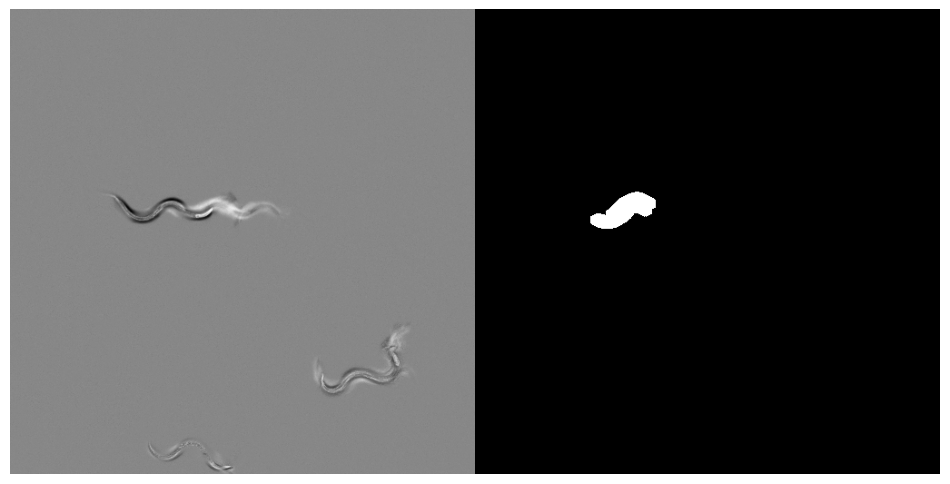

In [75]:
mask = getROIMask(
    frame,
    min_area=100,
    max_area=5000,
    thresh_block_size=11,
    thresh_C=10,
    dilation_size=5,
    keep_border_data=False,
    is_light_background=True,
)

image_utils.imshow(frame, mask)